# Загрузка библиотек 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import nbformat
import plotly.graph_objects as go 

from scipy.stats import normaltest, levene, norm
from scipy.optimize import curve_fit
from scipy.stats import f_oneway
from scipy.fft import fft, fftfreq, rfft, rfftfreq, irfft


sns.set_theme()
sns.set_palette("deep")

In [2]:
data_bpm = []
for i in range(1, 25):
    line_data = np.fromfile(f'data/data_bpm{i}.bin', dtype='short')
    data = line_data.reshape(-1, 4)
    df = pd.DataFrame(data, columns=['A', 'B', 'C', 'D'])
    data_bpm.append(df)
data_bpm[0]

A     B     C     D
0       -833 -1444 -1334 -1426
1       -643 -1234 -1104 -1402
2       -675 -1351 -1139 -1428
3       -583 -1502 -1147 -1385
4       -527 -1623  -995 -1265
...      ...   ...   ...   ...
249995 -1651 -2228 -2346 -2667
249996 -1789 -1987 -2276 -2519
249997 -2033 -1933 -2349 -2243
249998 -2215 -1868 -2448 -2181
249999 -2023 -1818 -2512 -2423

[250000 rows x 4 columns]

# Оптимизированный код

In [3]:
period = 368
data = data_bpm[0].iloc[20*period:].reset_index().drop('index', axis=1)

In [4]:
data

A     B     C     D
0      -3377 -2785 -3730 -3637
1      -3447 -2586 -3584 -3665
2      -3471 -2543 -3449 -3714
3      -3501 -2664 -3494 -3493
4      -3571 -2631 -3652 -3498
...      ...   ...   ...   ...
242635 -1651 -2228 -2346 -2667
242636 -1789 -1987 -2276 -2519
242637 -2033 -1933 -2349 -2243
242638 -2215 -1868 -2448 -2181
242639 -2023 -1818 -2512 -2423

[242640 rows x 4 columns]

In [5]:
def plot(data: pd.DataFrame, period: int, number_of_periods: int, start_record_number: int=0, columns=None, **plot_params):
    columns = columns if columns else data.columns
    data[start_record_number: start_record_number + number_of_periods*period][columns].plot(**plot_params)
    for i in range(number_of_periods+1):
        plt.axvline(x=start_record_number+i*period, ls='--', color='gray')

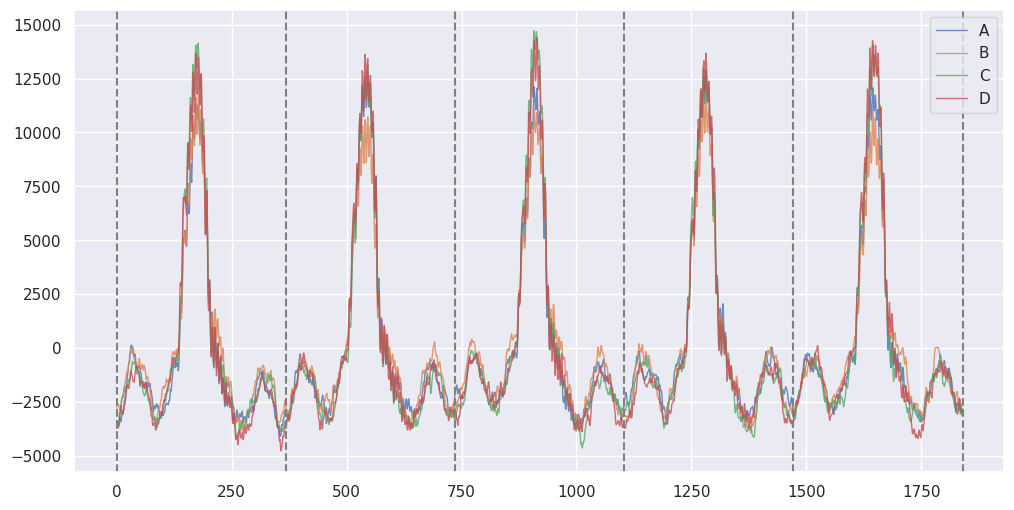

In [6]:
plot(data=data, period=period, start_record_number=0, number_of_periods=5, columns=[],
    lw=1, alpha=.8, figsize=(12, 6))

In [7]:
def periods_data(data: pd.Series, period: int):
    number_of_records = len(data)
    periods = data[:number_of_records // period * period].to_numpy().reshape(-1, period)
    periods_data = pd.DataFrame(periods.T)
    return periods_data

In [8]:
def periods_data_parameter(data: pd.Series, period: int, parameter: str, columns=[]):
    columns = columns if columns else data.columns
    result = pd.DataFrame()
    for column in columns:
        result[column] = periods_data(data[column], period).agg(parameter)
    return result

## Средние

<Axes: xlabel='Number of period', ylabel='Mean'>

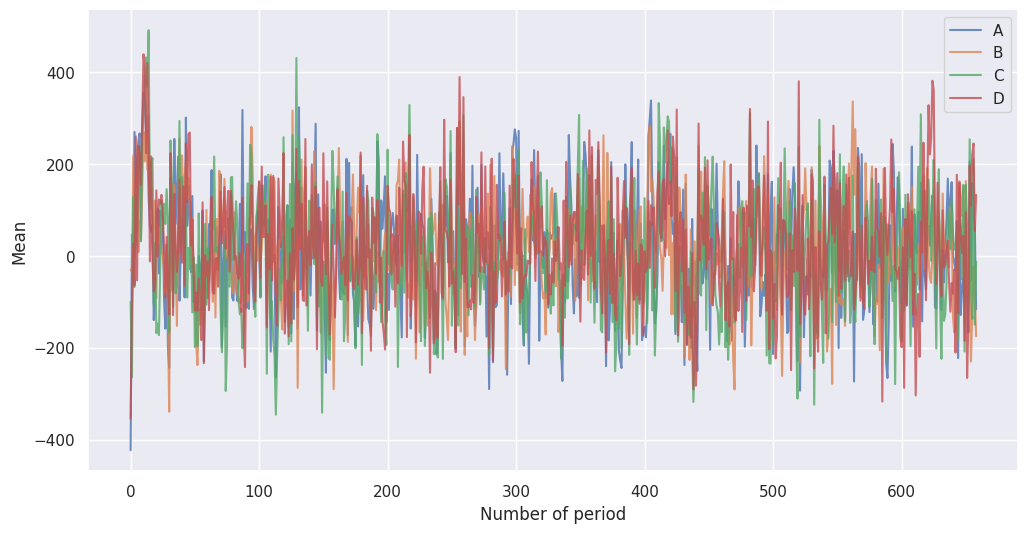

In [9]:
mean_data = periods_data_parameter(data, period, 'mean')
mean_data.plot(xlabel='Number of period', ylabel='Mean', alpha=.8, figsize=(12, 6))

In [10]:
f_oneway(mean_data['A'], mean_data['B'], mean_data['C'], mean_data['D'])

F_onewayResult(statistic=1.6097871856027783, pvalue=0.18500232290497012)

In [11]:
pd.DataFrame(mean_data.mean(), columns=['Mean'])

Mean
A   9.001765
B  11.046596
C   6.507381
D  20.735667

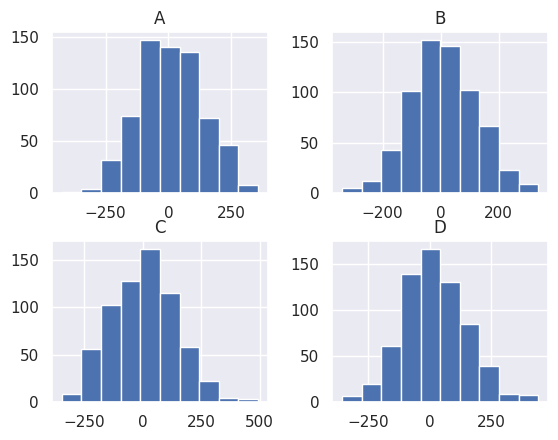

In [12]:
mean_data.hist();

In [13]:
pd.DataFrame(mean_data.mean(), columns = ['Mean of mean'])

Mean of mean
A      9.001765
B     11.046596
C      6.507381
D     20.735667

In [14]:
levene(*mean_data.to_numpy().T)

LeveneResult(statistic=8.867400015677692, pvalue=7.589655749870372e-06)

In [15]:
pd.DataFrame(mean_data.var(), columns = ['Variance of means'])

Variance of means
A       16233.679269
B       12427.469528
C       18513.976599
D       16279.328145

In [ ]:
data_mean = periods_data_parameter(data, period, 'mean')

test_anova, p_anova = f_oneway(data_mean['A'], data_mean['B'], data_mean['C'], data_mean['D'])
test_leven, p_leven = levene(data_mean['A'], data_mean['B'], data_mean['C'], data_mean['D'])

print(f'Критериый о равенстве средних: \nStatistics = {test_anova}, p-value = {p_anova}\n')
print(f'Критериый о равенстве дисперсий: \nStatistics = {test_leven}, p-value = {p_leven}')

## Среднеквадратичные отклонения

<Axes: xlabel='Number of period', ylabel='Standart deviation'>

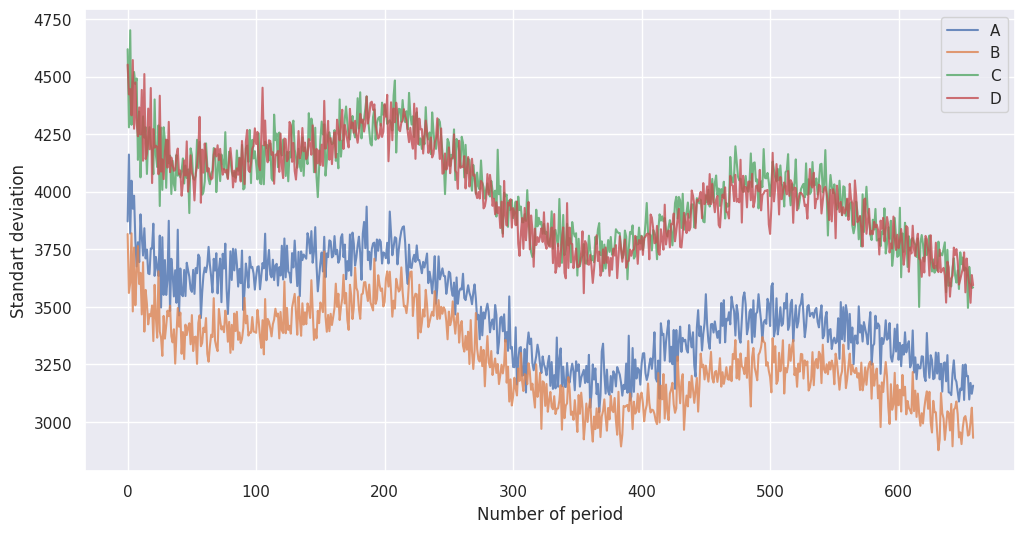

In [16]:
std_data = periods_data_parameter(data, period, 'std')
std_data.plot(xlabel='Number of period', ylabel='Standart deviation', alpha=.8, figsize=(12, 6))

In [17]:
f_oneway(*std_data.to_numpy().T)

F_onewayResult(statistic=2146.237918716715, pvalue=0.0)

In [18]:
levene(*std_data.to_numpy().T)

LeveneResult(statistic=4.1068339924078305, pvalue=0.00644072605719384)

array([[<Axes: title={'center': 'A'}>, <Axes: title={'center': 'B'}>],
       [<Axes: title={'center': 'C'}>, <Axes: title={'center': 'D'}>]],
      dtype=object)

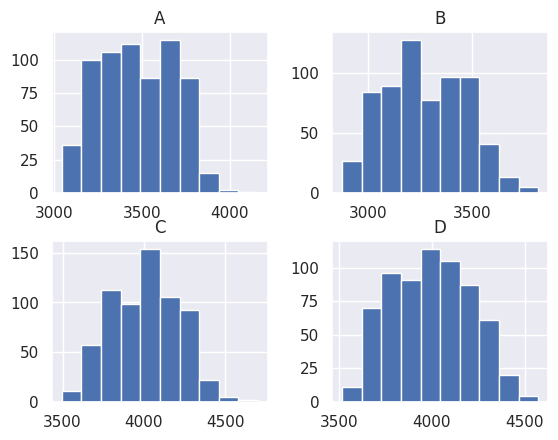

In [19]:
std_data.hist()

In [ ]:
data_std = periods_data_parameter(data, period, 'std')

test_anova, p_anova = f_oneway(data_std['A'], data_std['B'], data_std['C'], data_std['D'])
test_leven, p_leven = levene(data_std['A'], data_std['B'], data_std['C'], data_std['D'])

print(f'Критериый о равенстве средних: \nStatistics = {test_anova}, p-value = {p_anova}\n')
print(f'Критериый о равенстве дисперсий: \nStatistics = {test_leven}, p-value = {p_leven}')

## Максимумы

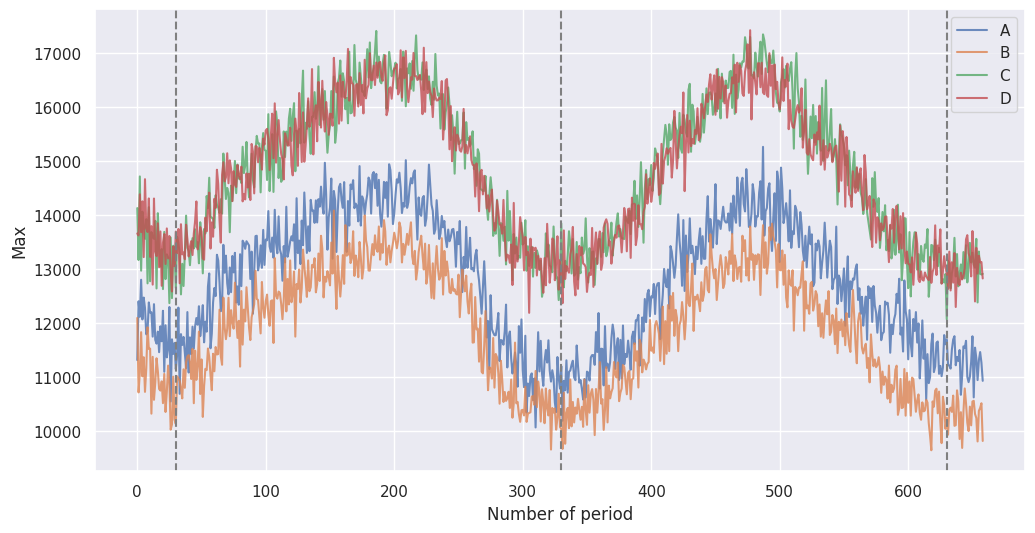

In [20]:
max_data = periods_data_parameter(data, period, 'max')
max_data.plot(xlabel='Number of period', ylabel='Max', alpha=.8, figsize=(12, 6))
plt.axvline(x=30, ls='--', color='gray')
plt.axvline(x=330, ls='--', color='gray')
plt.axvline(x=630, ls='--', color='gray')

In [21]:
f_oneway(*max_data.to_numpy().T)

F_onewayResult(statistic=927.2447376397844, pvalue=0.0)

In [22]:
levene(*max_data.to_numpy().T)

LeveneResult(statistic=18.439693411518586, pvalue=7.739939818468324e-12)

array([[<Axes: title={'center': 'A'}>, <Axes: title={'center': 'B'}>],
       [<Axes: title={'center': 'C'}>, <Axes: title={'center': 'D'}>]],
      dtype=object)

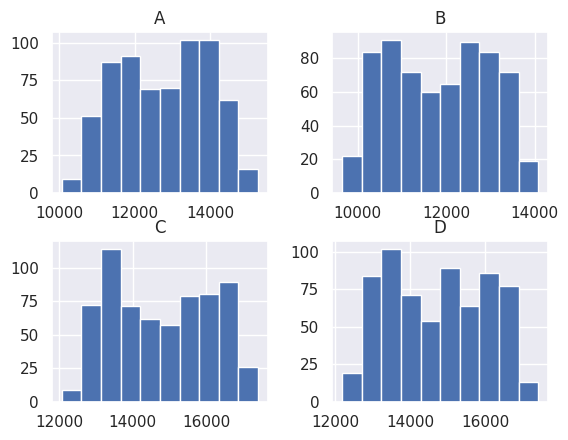

In [23]:
max_data.hist()

In [ ]:
data_max = periods_data_parameter(data, period, 'max')

test_anova, p_anova = f_oneway(data_max['A'], data_max['B'], data_max['C'], data_max['D'])
test_leven, p_leven = levene(data_max['A'], data_max['B'], data_max['C'], data_max['D'])

print(f'Критериый о равенстве средних: \nStatistics = {test_anova}, p-value = {p_anova}\n')
print(f'Критериый о равенстве дисперсий: \nStatistics = {test_leven}, p-value = {p_leven}')

## Минимумы

<Axes: xlabel='Number of period', ylabel='Min'>

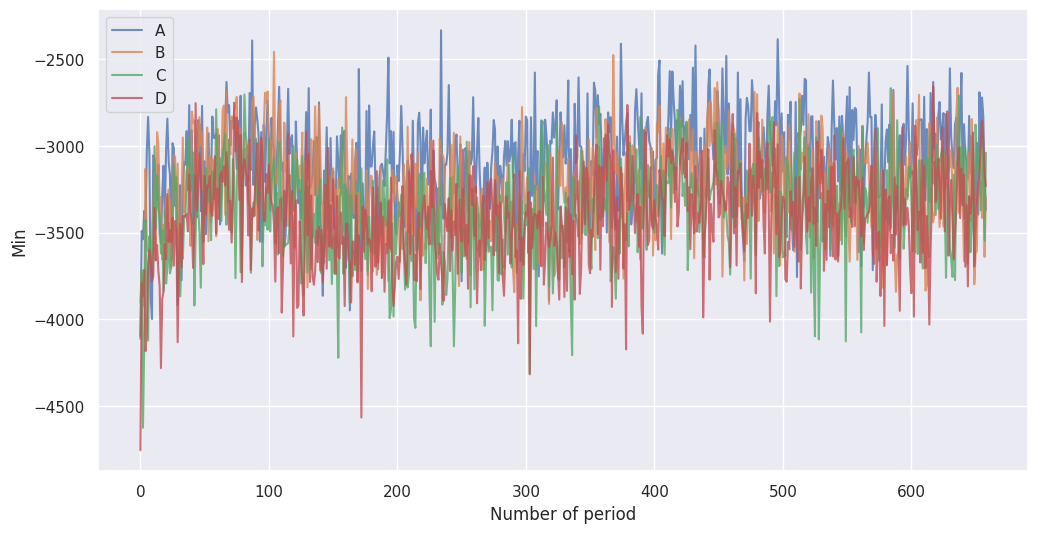

In [24]:
min_data = periods_data_parameter(data, period, 'min')
min_data.plot(xlabel='Number of period', ylabel='Min', alpha=.8, figsize=(12, 6))

In [25]:
f_oneway(*min_data.to_numpy().T)

F_onewayResult(statistic=193.44536486440276, pvalue=2.2972062266616695e-113)

In [26]:
levene(*min_data.to_numpy().T)

LeveneResult(statistic=0.08628145605491191, pvalue=0.967566796981439)

array([[<Axes: title={'center': 'A'}>, <Axes: title={'center': 'B'}>],
       [<Axes: title={'center': 'C'}>, <Axes: title={'center': 'D'}>]],
      dtype=object)

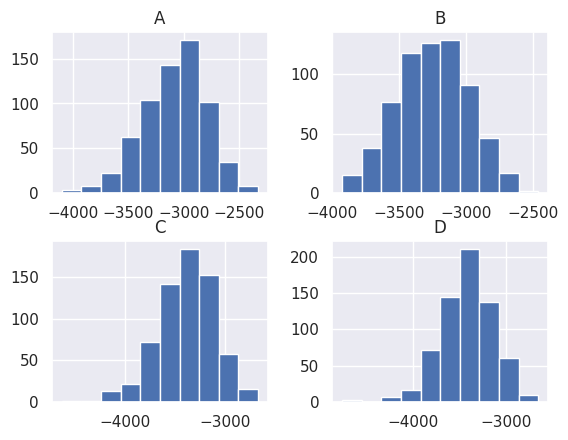

In [27]:
min_data.hist()

In [ ]:
data_min = periods_data_parameter(data, period, 'min')

test_anova, p_anova = f_oneway(data_min['A'], data_min['B'], data_min['C'], data_min['D'])
test_leven, p_leven = levene(data_min['A'], data_min['B'], data_min['C'], data_min['D'])

print(f'Критериый о равенстве средних: \nStatistics = {test_anova}, p-value = {p_anova}\n')
print(f'Критериый о равенстве дисперсий: \nStatistics = {test_leven}, p-value = {p_leven}')

In [28]:
for i in min_data.columns:
    print(f'{i}: p-value = {normaltest(min_data[i]).pvalue}')

A: p-value = 0.0002114646565843152
B: p-value = 0.051744508951062036
C: p-value = 4.8301333964867485e-06
D: p-value = 1.5868037787062317e-06


In [29]:
periods_data(data['A'], period)

0     1     2     3     4     5     6     7     8     9    ...   649   
0   -3377 -3169 -1971 -2455 -2849 -2763 -2557 -2513 -2405 -2019  ... -1643  \
1   -3447 -3139 -1969 -2359 -2897 -2847 -2533 -2449 -2407 -1915  ... -1625   
2   -3471 -3097 -1869 -2273 -2961 -2839 -2403 -2477 -2511 -2033  ... -1869   
3   -3501 -3035 -1701 -2149 -3091 -2701 -2569 -2361 -2389 -2133  ... -2217   
4   -3571 -3077 -1735 -2055 -3121 -2761 -2613 -2097 -2299 -2151  ... -2061   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
363 -3253 -3105 -3219 -2337 -2801 -2467 -2531 -2455 -1803 -2245  ... -1470   
364 -3189 -3065 -3129 -2277 -2919 -2555 -2641 -2701 -1731 -2291  ... -1365   
365 -2955 -2863 -3101 -2455 -2997 -2697 -2755 -2727 -1833 -2367  ... -1487   
366 -2877 -2573 -2947 -2701 -2899 -2659 -2701 -2747 -1927 -2629  ... -1673   
367 -3063 -2251 -2685 -2837 -2803 -2451 -2563 -2665 -2073 -2801  ... -1831   

      650   651   652   653   654   655   656   657   658  
0   -2007 -1145 -2255 -1419 -1585 -1073  -873 -1565 -1329  
1   -2035 -1477 -2491 -1373 -1497  -945  -961 -1643 -1431  
2   -2159 -1841 -2527 -1575 -1609  -983 -1121 -1977 -1487  
3   -2497 -2043 -2437 -1715 -1773 -1469 -1327 -2201 -1679  
4   -2663 -2203 -2481 -1653 -1849 -1781 -1329 -2215 -1831  
..    ...   ...   ...   ...   ...   ...   ...   ...   ...  
363  -924 -1506  -686 -1148 -1234  -794 -1374 -1186 -1410  
364 -1011 -1713  -715 -1271 -1217  -829 -1355 -1239 -1423  
365 -1019 -1815  -973 -1483 -1095  -871 -1565 -1131 -1561  
366 -1145 -1803 -1175 -1633  -987  -821 -1735 -1001 -1599  
367 -1169 -1943 -1339 -1685 -1023  -767 -1651 -1049 -1617  

[368 rows x 659 columns]

In [30]:
print(f'Period = {300}')
print('Amplitudes')
max_data.max() - max_data.min()

Period = 300
Amplitudes


A    5190
B    4434
C    5332
D    5227
dtype: int16

<Axes: xlabel='Number of period', ylabel='Min'>

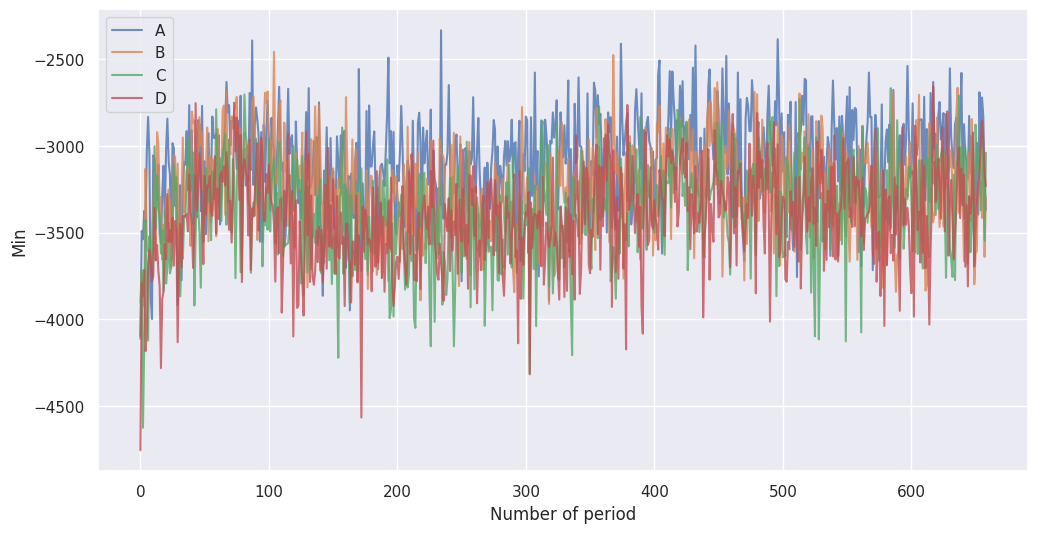

In [ ]:
periods_data_parameter(data, period, 'min').plot(xlabel='Number of period', ylabel='Min', alpha=.8, figsize=(12, 6))

## Распределения

In [ ]:
# Read data from a csv
z_data = periods_data(data['A'], period)

fig = go.Figure(data=[go.Surface(z=z_data.values)])

fig.update_layout(title='Непонятно что', autosize=False,
                  width=800, height=800,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

In [ ]:
hist_data = z_data[0].loc[z_data[0] > 0]

<Axes: >

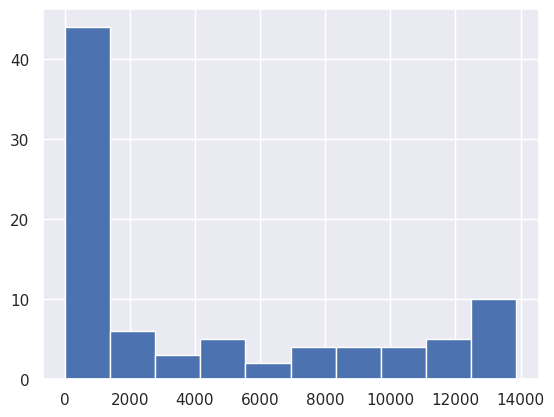

In [ ]:
i = 535
hist_data = z_data[i].loc[z_data[i] > 0]
hist_data.hist()

# Координаты центра масс

<Axes: >

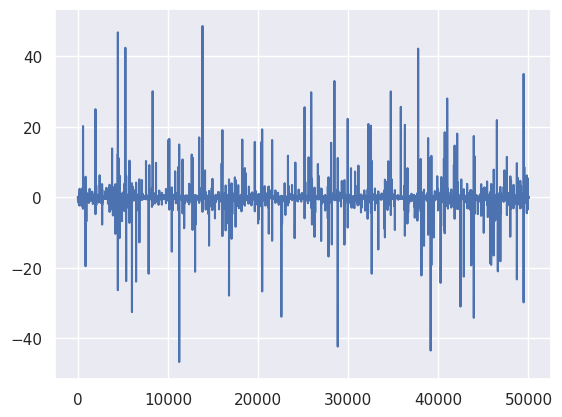

In [ ]:
ac_data = ((data['A'] - data['C']) / (data['A'] + data['C']))
ac_data.loc[abs(ac_data)<50].iloc[:50_000].plot()

<Axes: >

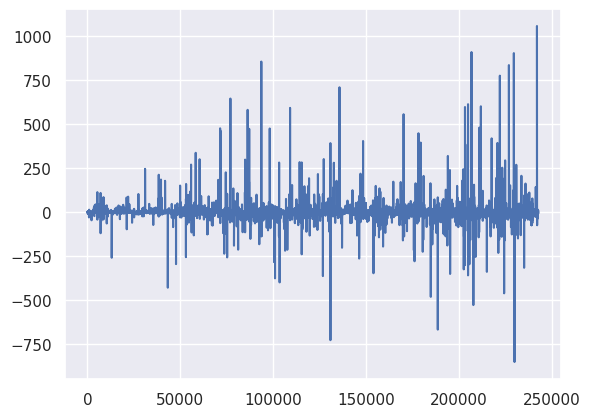

In [ ]:
bd_data = ((data['B'] - data['D']) / (data['B'] + data['D']))
bd_data.plot()

In [ ]:
bd_data[:1000].mean()

-0.19720537307755576

In [ ]:
bd_data.to_numpy().shape

(242640,)

# Применение Фурье анализа

## Scipy

In [ ]:
SAMPLE_RATE = 250 * 10^6
DURATION = period

In [ ]:
N = 368 # SAMPLE_RATE * DURATION
signal = periods_data(data['A'], period)[0]

yf = fft(signal)
xf = fftfreq(N, 1 / SAMPLE_RATE)

plt.plot(xf, np.abs(yf))
plt.show()

In [ ]:
# обратите внимание на r в начале имён функций
yf = rfft(signal)
xf = rfftfreq(N, 1/SAMPLE_RATE)

plt.plot(xf, np.abs(yf))
plt.show()

In [ ]:
# Максимальная частота составляет половину частоты дискретизации
points_per_freq = len(xf) / (SAMPLE_RATE / 2)

# Наша целевая частота - 4000 Гц
target_idx = int(points_per_freq * 4000)
yf[target_idx-2:target_idx+2] = 0

plt.plot(xf, np.abs(yf))
plt.show()

## NumPy

In [ ]:
periods_data(data['A'], period)[0].plot()

In [ ]:
t = np.linspace(0, 1, 368)

In [ ]:
t = np.linspace(0, 368, 368) # Временные отсчеты

signal = periods_data(data['A'], period)[0] # Периодический сигнал

# Выполняем преобразование Фурье
fft_result = np.fft.fft(signal)

# Вычисляем частоты, соответствующие результатам преобразования Фурье
freqs = np.fft.fftfreq(len(signal), t[1] - t[0])

# Выводим результаты
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(t, signal)
plt.xlabel('Время')
plt.ylabel('Амплитуда')
plt.title('Периодический сигнал')

plt.subplot(122)
plt.plot(freqs, np.abs(fft_result))
plt.xlabel('Частота')
plt.ylabel('Амплитуда')
plt.title('Спектр сигнала')

plt.tight_layout()
plt.show()
